# Lab #10
### By Denis Khryashchev (dk2926)

In [1]:
# download census data for businesses by ZIP code. the data is here http://www.census.gov/econ/cbp/download/
# $ for ((y=93; y<=99; y+=1)); do wget ftp://ftp.census.gov/Econ2001_And_Earlier/CBP_CSV/zbp$y\totals.zip
# $ for ((y=0; y<=9; y+=1)); do wget ftp://ftp.census.gov/econ200$y\/CBP_CSV/zbp0$y\totals.zip
# $ for ((y=10; y<=15; y+=1)); do wget ftp://ftp.census.gov/econ20$y\/CBP_CSV/zbp$y\totals.zip

In [85]:
# Importing modules to work with zip file and create and process dataframes
import zipfile
import pandas as pd
import numpy as np
import geopandas as gp
import pylab as plt
import os
import glob
import math

# Importing modules for clustering
from sklearn.cluster import KMeans
import sklearn.cluster
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN

# Allowing plotting inside the notebook
%matplotlib inline

# Tasks. 
## 1. get and prep your data

In [3]:
# All the zipfiles are stored locally
# Reading the zip files in the current directory
files = glob.glob("zbp*.zip")
print files

# Converting 2 digit years to 4 digits
def two2four (year):
    if 59 <= year <= 99:
        year += 1900 
    else:
        year += 2000
    return year

dataframes = []

#Unzipping the files
for z in files:
    zipped = zipfile.ZipFile(z)
    unzipped = zipped.open(zipped.infolist()[0])
    data = pd.read_csv(unzipped)
    year = two2four(int(z[3:5]))
    data['Year'] = year
    data.columns = data.columns.str.lower()
    dataframes.append(data)

business = pd.concat(dataframes)

['zbp02totals.zip', 'zbp03totals.zip', 'zbp04totals.zip', 'zbp05totals.zip', 'zbp06totals.zip', 'zbp07totals.zip', 'zbp08totals.zip', 'zbp09totals.zip', 'zbp10totals.zip', 'zbp11totals.zip', 'zbp12totals.zip', 'zbp13totals.zip', 'zbp94totals.zip', 'zbp95totals.zip', 'zbp96totals.zip', 'zbp97totals.zip', 'zbp98totals.zip', 'zbp99totals.zip']


In [4]:
print business.head(10)

       ap ap_nf city cty_name   emp emp_nf empflag  est             name  \
0     660   NaN  NaN      NaN    40    NaN     NaN   11   HOLTSVILLE, NY   
1       0   NaN  NaN      NaN     0    NaN       I  490       AGAWAM, MA   
2  170725   NaN  NaN      NaN  6866    NaN     NaN  566      AMHERST, MA   
3    3900   NaN  NaN      NaN   268    NaN     NaN   15      AMHERST, MA   
4    4032   NaN  NaN      NaN   169    NaN     NaN   23      AMHERST, MA   
5   23301   NaN  NaN      NaN   832    NaN     NaN   94        BARRE, MA   
6   33275   NaN  NaN      NaN  1515    NaN     NaN  212  BELCHERTOWN, MA   
7    7840   NaN  NaN      NaN   369    NaN     NaN   28    BLANDFORD, MA   
8    6661   NaN  NaN      NaN   195    NaN     NaN   19   BONDSVILLE, MA   
9   10502   NaN  NaN      NaN   395    NaN     NaN   70    BRIMFIELD, MA   

     qp1 qp1_nf stabbr  year   zip  
0    148    NaN    NaN  2002   501  
1      0    NaN    NaN  2002  1001  
2  39616    NaN    NaN  2002  1002  
3   1097    NaN

In [5]:
# Reading zip codes
ZIP_codes = gp.read_file('nyc-zip-code-tabulation-areas-polygons.geojson')
print ZIP_codes.head(5)

                                                 @id  BLDGpostalCode CTY_FIPS  \
0  http://nyc.pediacities.com/Resource/PostalCode...               0      081   
1  http://nyc.pediacities.com/Resource/PostalCode...               0      081   
2  http://nyc.pediacities.com/Resource/PostalCode...               0      081   
3  http://nyc.pediacities.com/Resource/PostalCode...               0      081   
4  http://nyc.pediacities.com/Resource/PostalCode...               0      081   

   OBJECTID          PO_NAME STATE ST_FIPS      Shape_Area    Shape_Leng  \
0         1  Jackson Heights    NY      36  20163283.87440  20624.692317   
1         2        Glen Oaks    NY      36  22606526.91390  23002.816039   
2         3    New Hyde Park    NY      36   6269333.41234  15749.161511   
3         4        Bellerose    NY      36  49418364.05770  35932.810639   
4         5    Fresh Meadows    NY      36  69385865.59430  38693.565676   

  borough                                           geom

In [6]:
# Groupping by ZIP and Year and transposing the resulting table
bus = business[['zip', 'year', 'est']].groupby(['zip', 'year']).sum().unstack().T

C:\Anaconda2\lib\site-packages\pandas\core\index.py:4281: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return np.sum(name == np.asarray(self.names)) > 1


In [7]:
# Converting the dataset into time series
bus = bus.reset_index()
bus.index = bus.year
bus.index = pd.to_datetime(bus.index, format='%Y')
print bus.head(10)

zip        level_0  year  501  1000  1001  1002  1003  1004  1005  1007  \
year                                                                      
1994-01-01     est  1994  NaN   NaN   439   450    10    47    92   182   
1995-01-01     est  1995    2     4   439   467    10    48    95   172   
1996-01-01     est  1996    4    11   433   487    13    47   101   183   
1997-01-01     est  1997    4     8   457   500    15    41   104   183   
1998-01-01     est  1998    3   NaN   444   490    14    31    95   183   
1999-01-01     est  1999    2   NaN   469   558    13    35    82   194   
2002-01-01     est  2002   11   NaN   490   566    15    23    94   212   
2003-01-01     est  2003    7   NaN   505   586    16    21    93   230   
2004-01-01     est  2004    8   NaN   500   584    15    43    97   232   
2005-01-01     est  2005    2   NaN   509   589    12    31    94   225   

zip         ...    99921  99922  99923  99925  99926  99927  99928  99929  \
year        ...       

In [8]:
bus = bus.drop(['level_0', 'year'], 1)
print bus.head(10)

zip         501    1000   1001   1002   1003   1004   1005   1007   1008   \
year                                                                        
1994-01-01    NaN    NaN    439    450     10     47     92    182     18   
1995-01-01      2      4    439    467     10     48     95    172     19   
1996-01-01      4     11    433    487     13     47    101    183     14   
1997-01-01      4      8    457    500     15     41    104    183     17   
1998-01-01      3    NaN    444    490     14     31     95    183     18   
1999-01-01      2    NaN    469    558     13     35     82    194     18   
2002-01-01     11    NaN    490    566     15     23     94    212     28   
2003-01-01      7    NaN    505    586     16     21     93    230     25   
2004-01-01      8    NaN    500    584     15     43     97    232     21   
2005-01-01      2    NaN    509    589     12     31     94    225     19   

zip         1009   ...    99921  99922  99923  99925  99926  99927  99928  

In [9]:
# Selecting Column names that correspond to meaningful zip code
proper_codes = []
print type(ZIP_codes.postalCode[1])
# Converting unicode to integer
ZIP_codes['postalCode'] = ZIP_codes['postalCode'].apply(lambda x: int(x))
zips = bus.columns.tolist()

print type(np.int64(zips[5]))
print type(ZIP_codes['postalCode'][5])

for k in zips:
    for v in ZIP_codes['postalCode']:
        if k == v:
            proper_codes.append(k)

print proper_codes

<type 'unicode'>
<type 'numpy.int64'>
<type 'numpy.int64'>
[10001L, 10002L, 10003L, 10004L, 10004L, 10004L, 10004L, 10005L, 10006L, 10007L, 10009L, 10010L, 10011L, 10012L, 10013L, 10014L, 10016L, 10017L, 10018L, 10019L, 10020L, 10021L, 10022L, 10023L, 10024L, 10025L, 10026L, 10027L, 10028L, 10029L, 10030L, 10031L, 10032L, 10033L, 10034L, 10035L, 10035L, 10036L, 10037L, 10038L, 10039L, 10040L, 10041L, 10043L, 10044L, 10045L, 10047L, 10047L, 10048L, 10055L, 10065L, 10069L, 10075L, 10080L, 10081L, 10096L, 10103L, 10104L, 10105L, 10106L, 10107L, 10110L, 10111L, 10112L, 10115L, 10118L, 10119L, 10120L, 10121L, 10122L, 10123L, 10128L, 10151L, 10152L, 10153L, 10154L, 10155L, 10158L, 10162L, 10165L, 10166L, 10167L, 10168L, 10169L, 10170L, 10171L, 10172L, 10173L, 10174L, 10175L, 10176L, 10177L, 10178L, 10196L, 10196L, 10203L, 10260L, 10265L, 10270L, 10271L, 10275L, 10278L, 10279L, 10280L, 10281L, 10282L, 10285L, 10286L, 10301L, 10302L, 10303L, 10304L, 10305L, 10306L, 10307L, 10308L, 10309L, 1031

In [10]:
# Applying the selection
time_series = bus[proper_codes]
print time_series.head(15)

zip         10001  10002  10003  10004  10004  10004  10004  10005  10006  \
year                                                                        
1994-01-01   6999   1784   3256   1115   1115   1115   1115   1076   1061   
1995-01-01   7088   1819   3377   1124   1124   1124   1124   1109   1002   
1996-01-01   7075   1919   3417   1133   1133   1133   1133   1216    969   
1997-01-01   7154   2049   3535   1173   1173   1173   1173   1227    990   
1998-01-01   7254   2003   3649   1176   1176   1176   1176   1270   1030   
1999-01-01   7233   2085   3659   1233   1233   1233   1233   1242   1059   
2002-01-01   7141   2269   3616   1253   1253   1253   1253   1244    934   
2003-01-01   7084   2402   3704   1252   1252   1252   1252   1200    862   
2004-01-01   7370   2551   3776   1283   1283   1283   1283   1226    869   
2005-01-01   7312   2682   3867   1260   1260   1260   1260   1214    870   
2006-01-01   7415   2686   3909   1311   1311   1311   1311   1259    874   

## 2. cluster the NUMBER OF ESTABLISHMENTS time series with K-means in **a few** clusters (as discussed there is no real good, sound way to decide what a good number is here. try a few options, keeping in mind a few is more than a couple, but i recommand you stay within the single digit numbers) +

## + 3. plot the cluster centers (if you used K means those are the means of the clusters). you can plot for example the cluster centers overlayed on each time series (using the alpha channel to control the opacity in the plot may be helpful here).

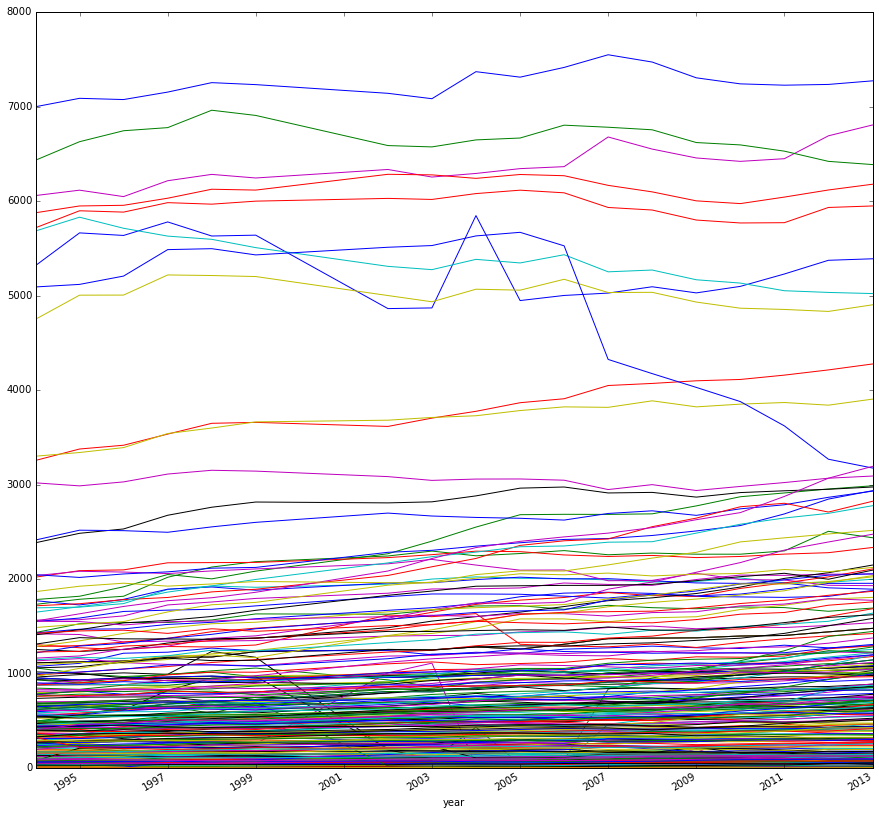

In [11]:
# Plotting the time series
plot1 = time_series.plot(figsize=(15, 15), legend=0)

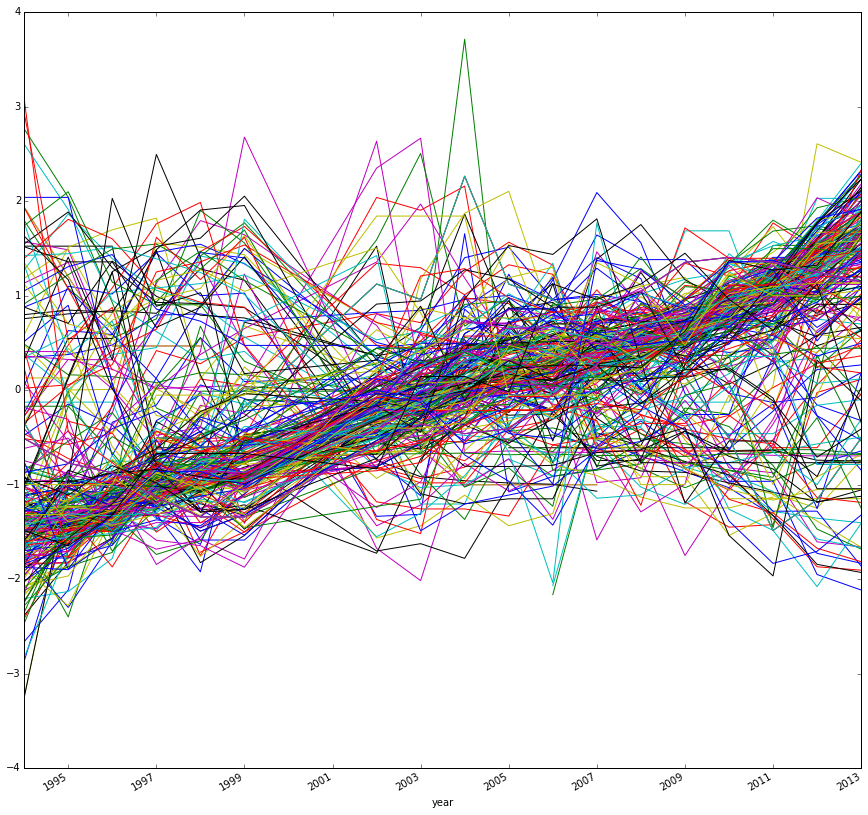

In [12]:
# Normalizing time series
time_series = (time_series - time_series.mean())/time_series.std()
# Plotting Normalized time series
plot2 = time_series.plot(figsize=(15, 15), legend=0)

In [27]:
# Clustering using K-means
# removing NaN values
time_series.fillna(0, inplace=1)
time_series_t = time_series.T

Silhouette Scores:  [0.51794272771434757, 0.49375198327002762, 0.26276979299843911, 0.47972541108453476, 0.29271715264706999, 0.36640163245519181, 0.395450404431611]


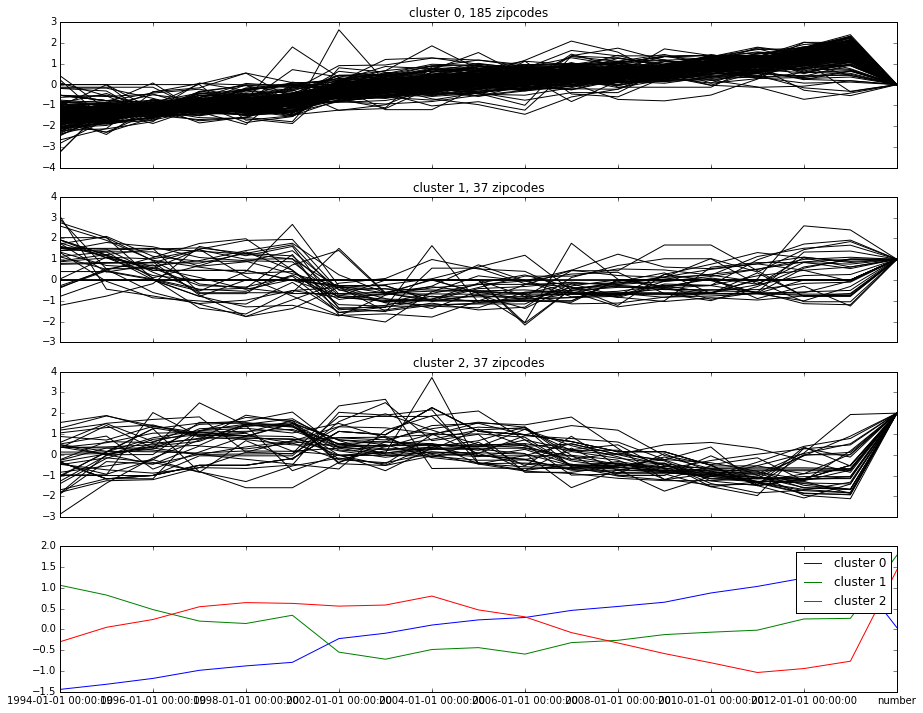

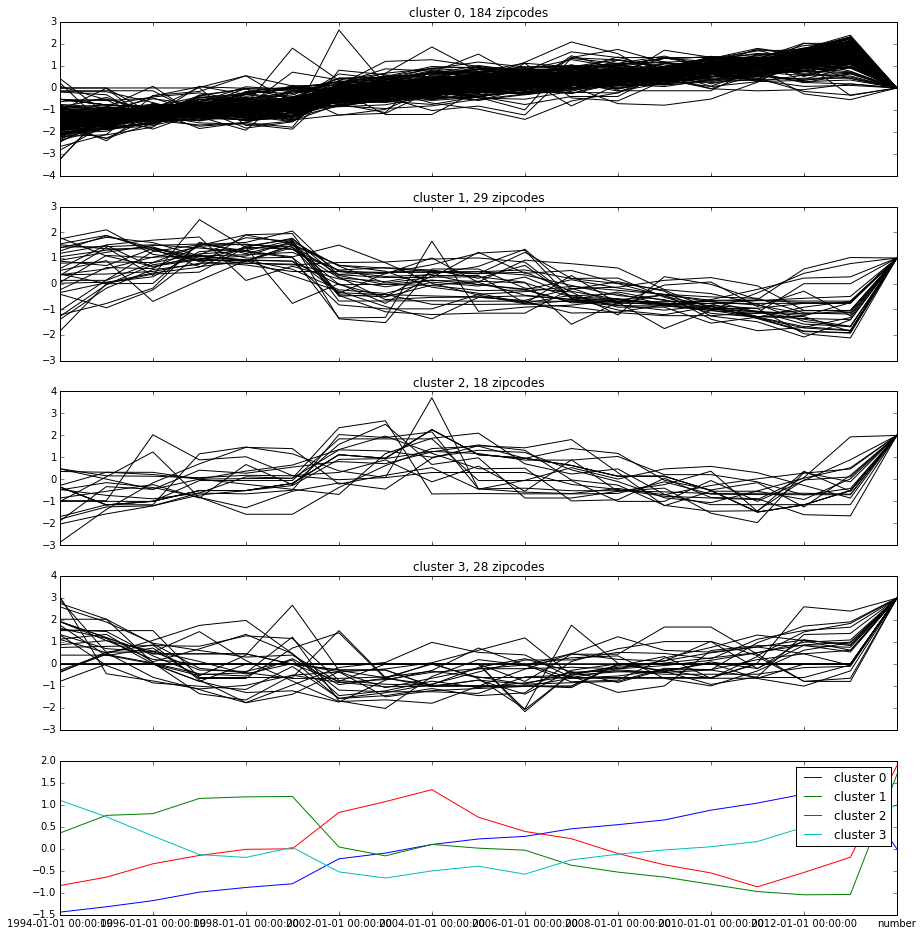

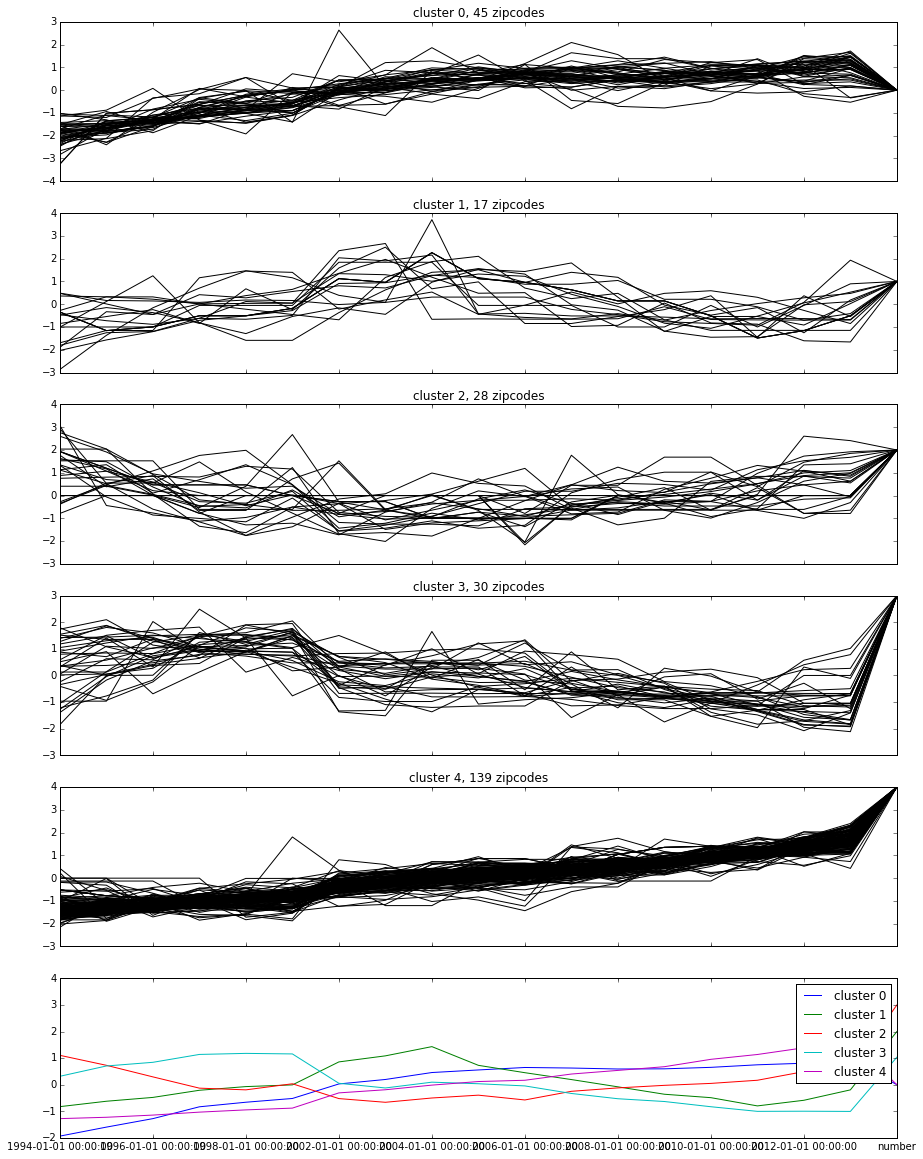

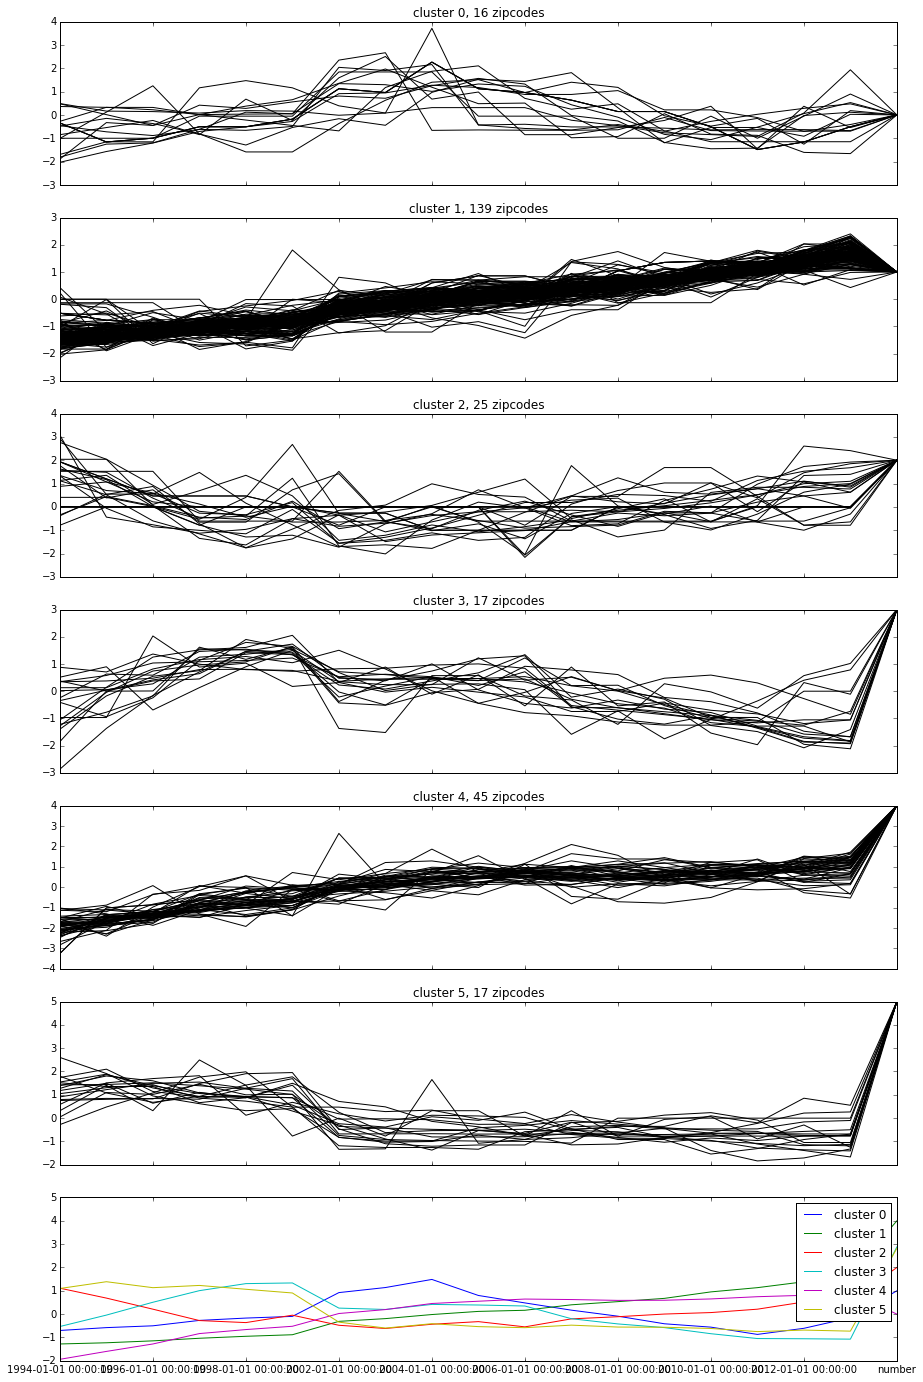

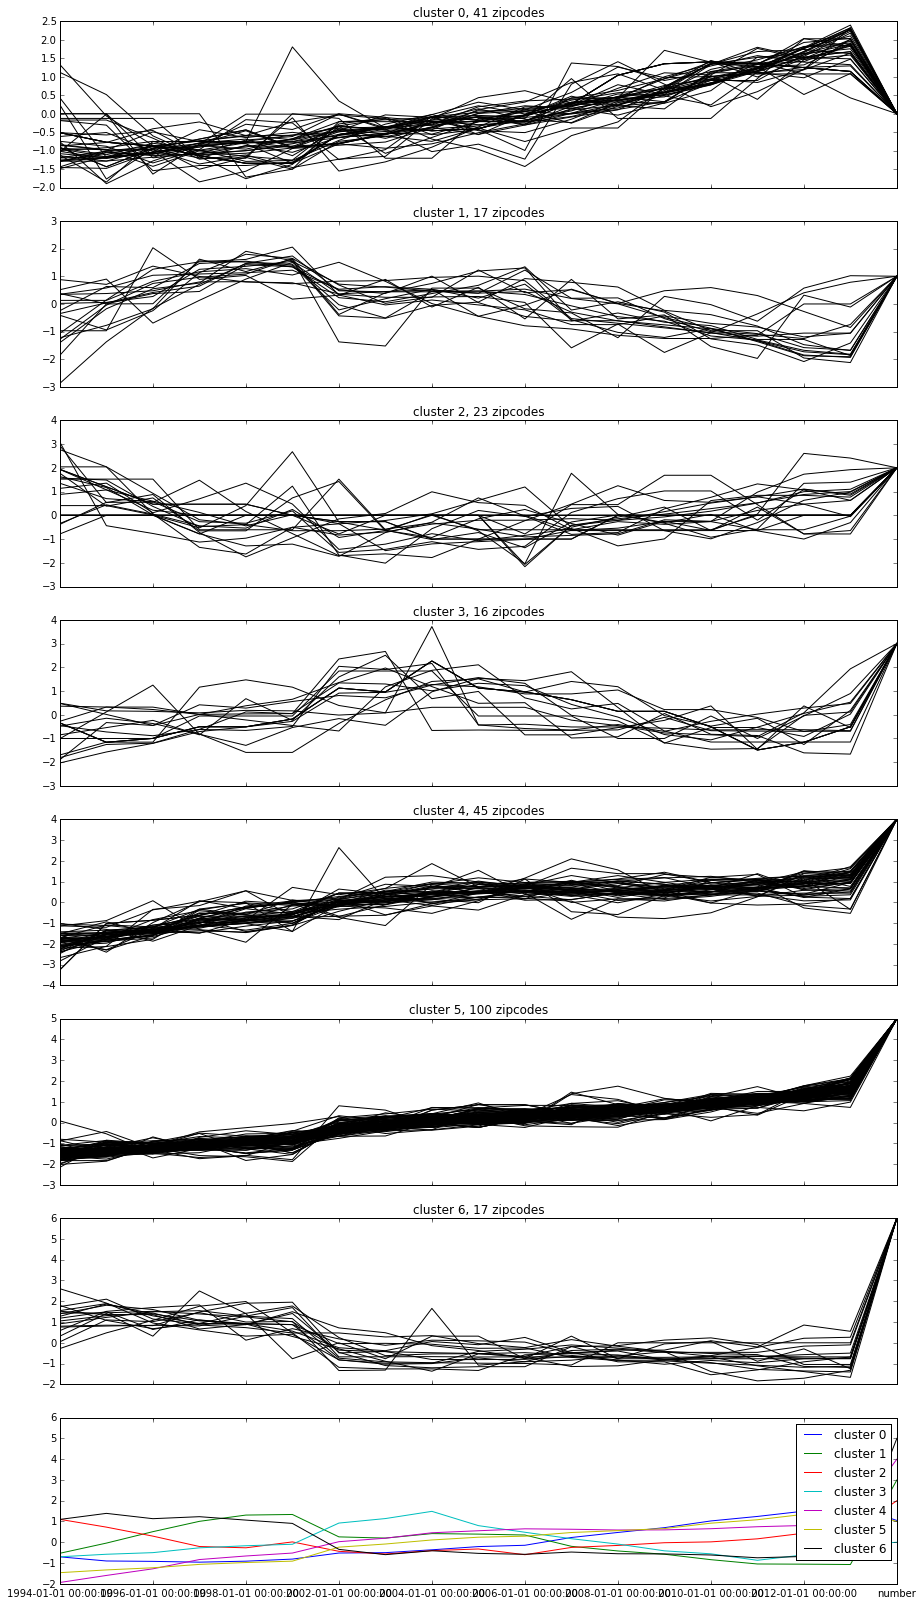

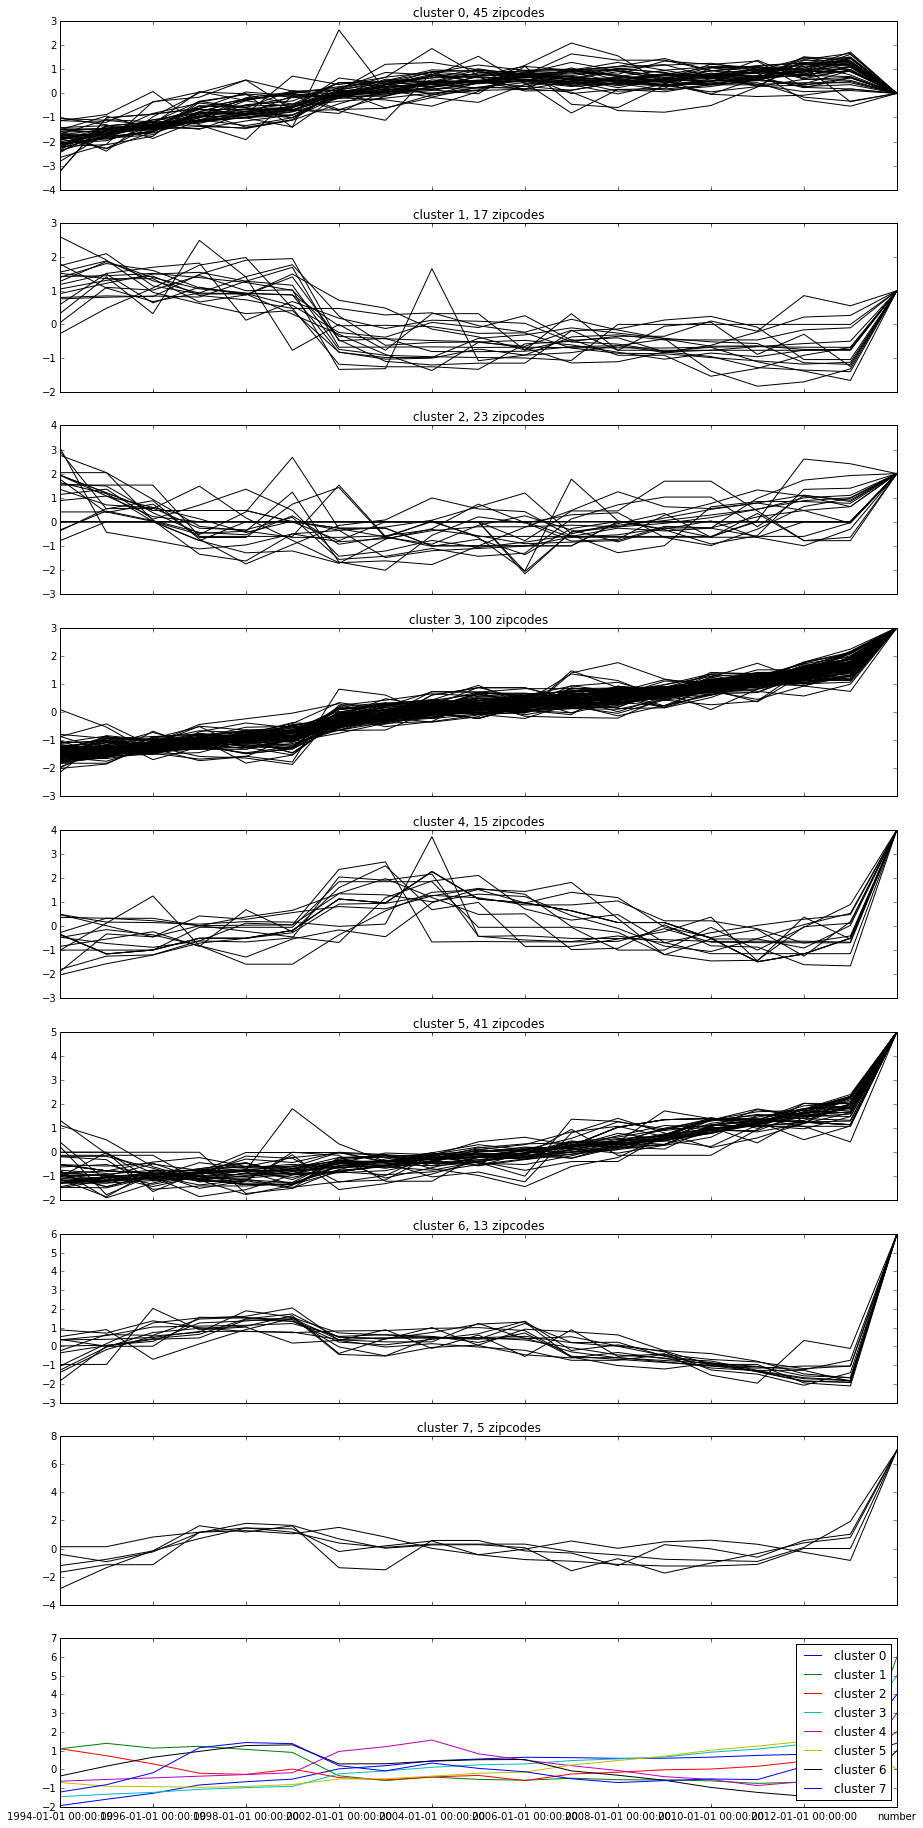

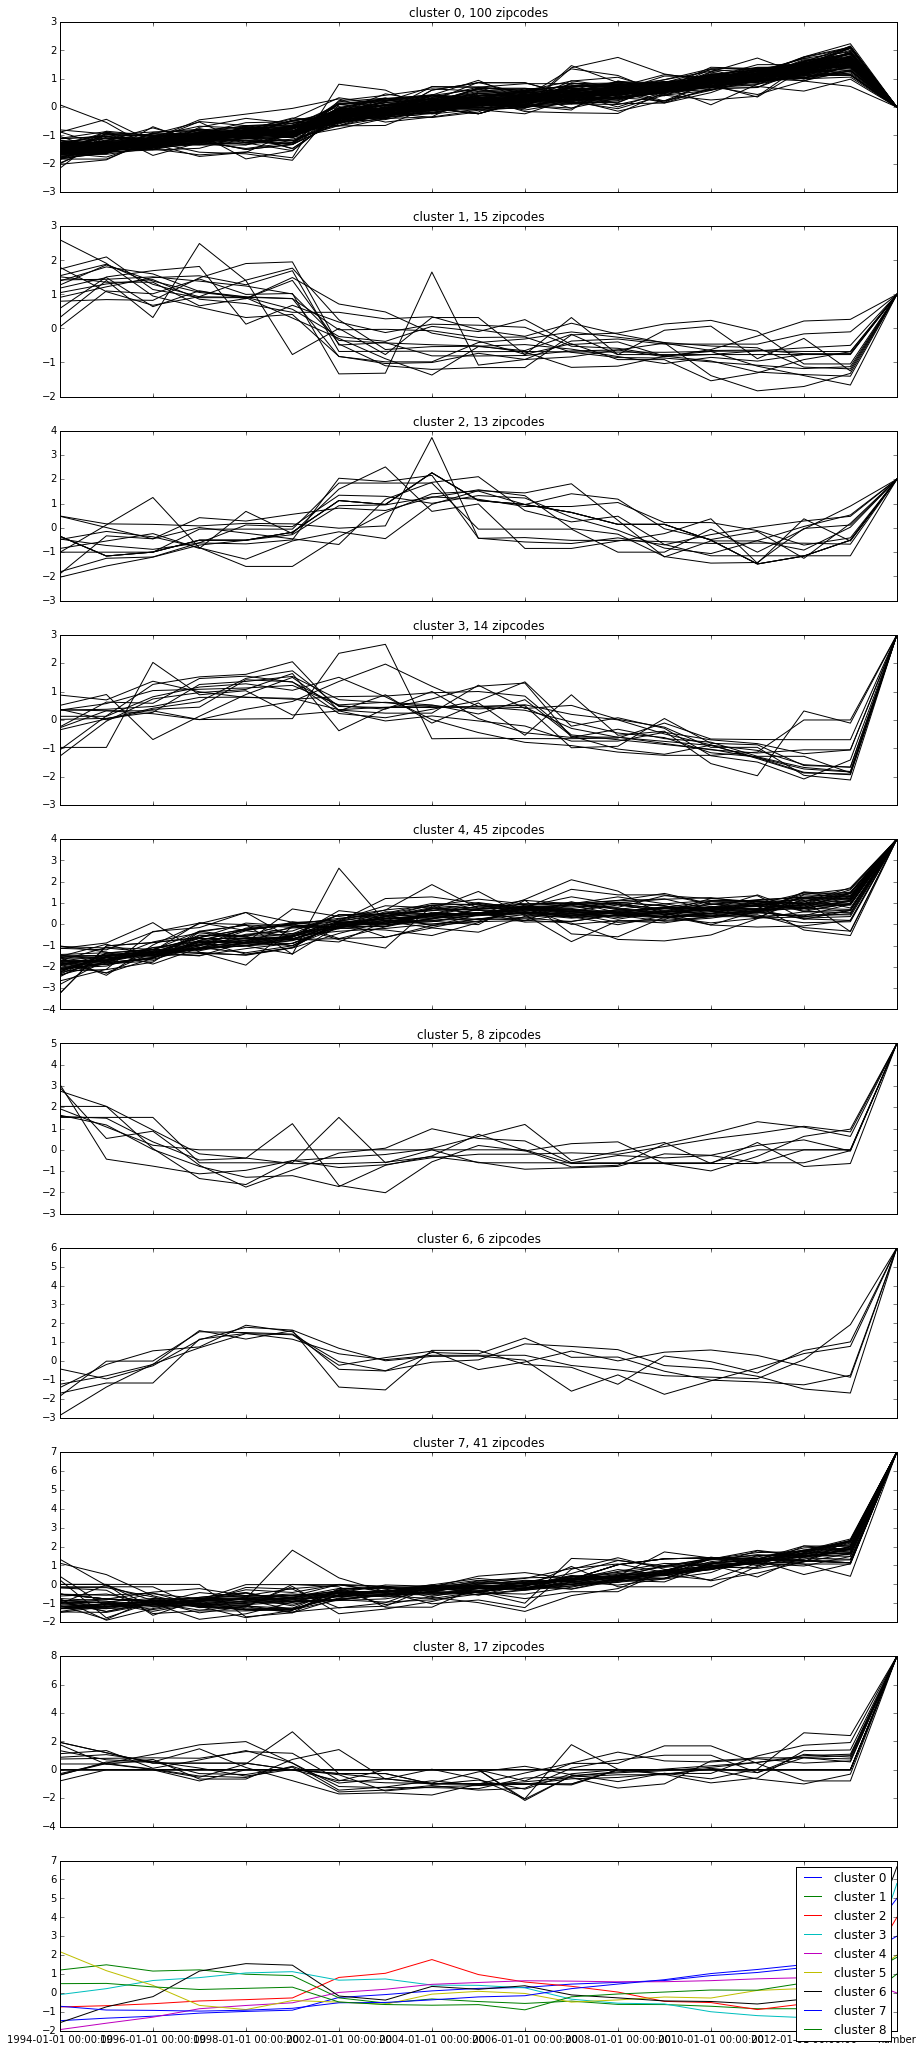

In [80]:
# Running k means clustering for 3 clusters
scores = []
for n in range(3, 10): 
    K_means = sklearn.cluster.KMeans(n_clusters=n)
    K_means.fit(time_series_t.values)
    labels = K_means.labels_
    centers = K_means.cluster_centers_
    
    # Calculating silhouette scores
    s_score = silhouette_score(time_series_t.values, K_means.labels_)
    scores.append(s_score)
    
    # Assigning cluster number
    time_series_t['number'] = labels
    
    grouped = time_series_t.groupby('number')
    
    fig, axes = plt.subplots(n+1, figsize=(15, n*4), sharex = 'all')
    for l, g in grouped:
        g.T.plot(ax=axes[l], legend=0, c='k')
        axes[l].set_title('cluster %d, %d zipcodes'% (l, len(g)))
        
    for i, c in enumerate(centers):
        pd.Series(c).plot(ax=axes[-1], label='cluster %d'% (i ))
    
    plot = plt.legend()
print "Silhouette Scores: ", scores

## 4. Use another clustering algorithm (of your choice)4. Use another clustering algorithm (of your choice)

In [105]:
# DBSCAN
# Running clustering for epsilons 0 to 5
for k in range(1, 5):
    db = DBSCAN(eps=k).fit(time_series_t.values)

    labels = (db.labels_).astype(int)
    count = len(set(labels)) - 1

    print(labels)
    print("Silhouette Scores: %s" % silhouette_score(time_series_t.values, labels))
    print('Number of clusters: %d' % count)

[-1  0  0  0  0  0  0 -1 -1 -1  0 -1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  1  0  0 -1  0  0  0  0  1  0  0  0 -1  2 -1  0 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1  0 -1  0 -1  0  0  0  0  1 -1 -1  1 -1  1  0  0  0
  0  0 -1  0  0 -1 -1  3  3 -1 -1 -1 -1 -1 -1 -1  0 -1 -1  3 -1 -1  0 -1 -1
 -1 -1 -1 -1 -1  1  0  0  1  0 -1  0  3  0  3  3  3  0  1  3  0  3  0  0  0
  3  0  0  0  0  3  0  0  0  0  0  3  0  1  0  0  0  3  3  0 -1  3  3 -1 -1
  0  0  0  1  0 -1 -1  0  0 -1  0  0  3  0  0  0 -1 -1 -1  0  0  1 -1  0  0
  0  3  0  1  0 -1  1 -1 -1  0  0  0  0 -1  1 -1  0 -1 -1 -1  1 -1  0  0  0
 -1  3 -1  2  2  2  2 -1 -1]
Silhouette Scores: 0.149728407981
Number of clusters: 4
[-1  0  0  0  0  0  0 -1  1 -1  0 -1  2  2 -1  2 -1  1  0 -1 -1  4 -1  2  2
  2  0  0  2  0  0  0  0  2  0  0  0 -1  3 -1  0  2  2 -1  3 -1 -1 -1 -1 -1
 -1

## 5. overlay your data on a NYC map: you can use shapefiles for the zip codes and different colors for different clusters

## 6. Compare the results of the 2 algorithms

### K-means algorithm demonstrated bigger versatility in terms of number of clusters. One can define the number of clusters and compare the accuracy, using silhouette scores. As For DBScan, one can only specify the epsilon and minimal number of points, which can only allow to define number of clusters indirectly. 
### K means showed better silhouette scores for 3 clusters, while DBScan showed better scores for 5 clusters.

## 7. attempt an interpretation. this is dangerous ground: clustering is an exploratory tool so you do not want to jump to conclusions because you see some clusters! but seeing structure in your data can inform your next moves as an investigator. 